In [41]:
# -*- coding: utf-8 -*-
import re
import matplotlib
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import accuracy_score
from sklearn.multiclass import OneVsRestClassifier
from sklearn.metrics import multilabel_confusion_matrix
from sklearn.metrics import roc_auc_score
from nltk.corpus import stopwords
stop_words = set(stopwords.words('english'))
from sklearn.svm import LinearSVC
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.pipeline import Pipeline
import seaborn as sns

In [30]:
def distribution_check(dist_data): 
    print(dist_data['toxic'].value_counts(dropna=False))
    print(dist_data['severe_toxic'].value_counts(dropna=False))
    print(dist_data['obscene'].value_counts(dropna=False))
    print(dist_data['threat'].value_counts(dropna=False))
    print(dist_data['insult'].value_counts(dropna=False))
    print(dist_data['identity_hate'].value_counts(dropna=False))
    
    rows_with_1 = dist_data.apply(lambda x: True if 1 in list(x) else False, axis=1)
    num_rows = len(rows_with_1[rows_with_1 == True].index)
    print("Number of Rows that has atleast 1 in any column: ", num_rows)

In [31]:
train_data = pd.read_csv("./train.csv", encoding="utf-8")
test_data = pd.read_csv("./test.csv", encoding="utf-8")

In [32]:
X_train=train_data["comment_text"]
y_train=train_data.iloc[:,1:]
X_test=test_data["comment_text"]
y_test=test_data.iloc[:,2:]

In [33]:
print(X_train.shape)
print(X_test.shape)
print(y_train.shape)
print(y_test.shape)

print(y_train.columns)
print(y_test.columns)

(143609,)
(63612,)
(143609, 6)
(63612, 6)
Index(['toxic', 'severe_toxic', 'obscene', 'threat', 'insult',
       'identity_hate'],
      dtype='object')
Index(['toxic', 'severe_toxic', 'obscene', 'threat', 'insult',
       'identity_hate'],
      dtype='object')


In [21]:
categories = ['toxic', 'severe_toxic', 'obscene', 'threat', 'insult', 'identity_hate']
print("Training data")
distribution_check(y_train)
print("\n\nTesting data")
distribution_check(y_test)

Training data
0    129822
1     13787
Name: toxic, dtype: int64
0    142182
1      1427
Name: severe_toxic, dtype: int64
0    135995
1      7614
Name: obscene, dtype: int64
0    143178
1       431
Name: threat, dtype: int64
0    136541
1      7068
Name: insult, dtype: int64
0    142350
1      1259
Name: identity_hate, dtype: int64
Number of Rows that has atleast 1 in any column:  14618


Testing data
0    57522
1     6090
Name: toxic, dtype: int64
0    63245
1      367
Name: severe_toxic, dtype: int64
0    59921
1     3691
Name: obscene, dtype: int64
0    63401
1      211
Name: threat, dtype: int64
0    60185
1     3427
Name: insult, dtype: int64
0    62900
1      712
Name: identity_hate, dtype: int64
Number of Rows that has atleast 1 in any column:  6243


In [25]:
def run(classifier,name):
    prediction_final = pd.DataFrame(columns=['toxic', 'severe_toxic', 'obscene', 'threat', 'insult', 'identity_hate'])
    for category in categories:
        print('... Processing {}'.format(category))
        # train the model using X_dtm & y
        classifier.fit(X_train, y_train[category])
        # compute the testing accuracy
        prediction = classifier.predict(X_test)
        prediction_final[category]=prediction
        print('Test accuracy is {}'.format(accuracy_score(y_test[category], prediction)))
    prediction_final.to_csv(name)

In [26]:
NB_pipeline = Pipeline([
                ('tfidf', TfidfVectorizer(stop_words=stop_words)),
                ('clf', OneVsRestClassifier(MultinomialNB(
                    fit_prior=True, class_prior=None))),
            ])
run(NB_pipeline,'naive_bayes.csv')

... Processing toxic
Test accuracy is 0.9224202980569703
... Processing severe_toxic
Test accuracy is 0.9942306483053512
... Processing obscene
Test accuracy is 0.9486103250958938
... Processing threat
Test accuracy is 0.9966830157831855
... Processing insult
Test accuracy is 0.9485946047915488
... Processing identity_hate
Test accuracy is 0.9888071433062944


In [27]:
LogReg_pipeline = Pipeline([
                ('tfidf', TfidfVectorizer(stop_words=stop_words)),
                ('clf', OneVsRestClassifier(LogisticRegression(solver='sag'), n_jobs=1)),
            ])
run(LogReg_pipeline,'Logistic_Regression.csv')

... Processing toxic
Test accuracy is 0.9368358171414198
... Processing severe_toxic
Test accuracy is 0.99317738791423
... Processing obscene
Test accuracy is 0.9665629126579891
... Processing threat
Test accuracy is 0.9967301766962209
... Processing insult
Test accuracy is 0.9637804187889077
... Processing identity_hate
Test accuracy is 0.9901905300886625


In [28]:
SVC_pipeline = Pipeline([
                ('tfidf', TfidfVectorizer(stop_words=stop_words)),
                ('clf', OneVsRestClassifier(LinearSVC(), n_jobs=1)),
            ])
run(SVC_pipeline,'svc.csv')

... Processing toxic
Test accuracy is 0.9260045274476514
... Processing severe_toxic
Test accuracy is 0.992831541218638
... Processing obscene
Test accuracy is 0.963308809658555
... Processing threat
Test accuracy is 0.9967773376092561
... Processing insult
Test accuracy is 0.9614852543545243
... Processing identity_hate
Test accuracy is 0.9903477331321134


In [51]:
def read_files(path):
    data = pd.read_csv(path, encoding="utf-8")
    return data

# bert_result = read_files("./test_results_3epoch_128_32_newdata_output.csv")
svc_result = read_files("./svc.csv")
lin_reg_result = read_files("./Logistic_Regression.csv")
naive_result = read_files("./naive_bayes.csv")

print(svc_result.shape)
print(lin_reg_result.shape)
print(naive_result.shape)
print(y_test.shape)

(63612, 7)
(63612, 7)
(63612, 7)
(63612, 6)


In [35]:
def calculate_metrics(cm):
    result_metric = []
    for entries in cm:
        TP = entries[1][1]
        FP = entries[1][0]
        FN = entries[0][1]
        TN = entries[0][0]
#         Uncomment if you want the metrics to run for 0 prediction
#         TP = entries[0][0]
#         FP = entries[0][1]
#         FN = entries[1][0]
#         TN = entries[1][1]
        # Precision
        PPV = TP/(TP+FP)
        # Sensitivity/ Recall
        TPR = TP/(TP+FN)
        # Specificity
        TNR = TN/(TN+FP) 
        # Fall out or false positive rate
        FPR = FP/(FP+TN)
        # False discovery rate
        FDR = FP/(TP+FP)
        # Accuracy
        ACC = (TP+TN)/(TP+FP+FN+TN)
        # F1 Score
        F1 = 2*((PPV*TPR)/(PPV+TPR))
#     return PPV, TPR, ACC, F1
        result_metric.append([PPV, TPR, ACC, F1])
    return result_metric

In [80]:
def ensemble(weight1, weight2, weight3, threshold):
    en_data = y_test.copy()
    total_weight = weight1 + weight2 + weight3
    new_naive_result = naive_result.select_dtypes(exclude=['object']) * weight1
    new_svc_result = svc_result.select_dtypes(exclude=['object']) * weight2
    new_lin_result = lin_reg_result.select_dtypes(exclude=['object']) * weight3
#     print(new_bert_result[:10])
#     print(new_svc_result[:10])
#     print(new_lin_result[:10])
#     jai = new_bert_result.add(new_svc_result, fill_value=0)
# #     print(pd.concat([new_bert_result,new_svc_result, new_lin_result]))
#     print(jai.iloc[:10, 1:])
#     en_data = jai.add(new_lin_result, fill_value=0)
#     print(en_data.iloc[:10, 1:])
    
    col_names =  ['toxic', 'severe_toxic', 'obscene', 'threat', 'insult', 'identity_hate']
    my_df  = pd.DataFrame(columns = col_names)
    my_df['toxic'] = new_naive_result['toxic'] + new_svc_result['toxic'] + new_lin_result['toxic']
    my_df['severe_toxic'] = new_naive_result['severe_toxic'] + new_svc_result['severe_toxic'] + new_lin_result['severe_toxic']
    my_df['obscene'] = new_naive_result['obscene'] + new_svc_result['obscene'] + new_lin_result['obscene']
    my_df['threat'] = new_naive_result['threat'] + new_svc_result['threat'] + new_lin_result['threat']
    my_df['insult'] = new_naive_result['insult'] + new_svc_result['insult'] + new_lin_result['insult']
    my_df['identity_hate'] = new_naive_result['identity_hate'] + svc_result['identity_hate'] + new_lin_result['identity_hate']


    for i in col_names:
        my_df[i]=my_df[i].apply(lambda x: 1 if float(x)>=threshold else 0)
        
#     for i in range(0, len(my_df.index)):
#         for j in range(1, len(my_df.columns)):
#             my_df.iloc[i, j] = 1 if my_df.iloc[i, j] >=0.5 else 0
#             if my_df.iloc[i, j] >=0.5:
#                 my_df.iloc[i, j] = 1
#                 print(my_df.iloc[i, j])
#     my_df['toxic'] = my_df['toxic'].astype(int)
#     my_df['severe_toxic'] = my_df['severe_toxic'].astype(int)
#     my_df['obscene'] = my_df['obscene'].astype(int)
#     my_df['toxic'] = my_df['toxic'].astype(int)
#     my_df['toxic'] = my_df['toxic'].astype(int)
#     my_df['toxic'] = my_df['toxic'].astype(int)
    

    my_df[col_names] = my_df[col_names].applymap(np.int64)
    cm = multilabel_confusion_matrix(y_test.iloc[:, :],my_df.iloc[:, :])
    result_metric = calculate_metrics(cm)
    for values in result_metric:
        print("\n")
        print ("Precision", values[0])
        print ("Recall", values[1])
        print ("Accuracy", values[2])
        print ("F1 score", values[3]) 
#     print(roc_auc_score(y_test.iloc[:, :],my_df.iloc[:, :]))
    print("\n")
    for i in range(0,6):
#         print(roc_auc_score(y_test.iloc[:, i],my_df.iloc[:, i-1]))
        prin
Precision 0.7883415435139574
Recall 0.578433734939759
Accuracy 0.9247311827t(roc_auc_score(y_test.iloc[:, i],my_df.iloc[:, i]))
    return result_metric

In [37]:
def hyper_parameter_tuning():
    array = np.linspace(0,1,11)
    print(array)
    high = 0
    parameter_set = None
    with open("./hyper_tuning_result1_ver2.txt", "w") as fp:
        for i in array:
            for j in array:
                for k in array:
                    for l in array[1:-2]:
                        en_data = ensemble(i, j, k ,l)
                        fp.write(str(i) +" "+ str(j) +" "+ str(k) +" "+str(l))
                        fp.write("\n")
                        for values in en_data:
                            fp.write("\n")
                            fp.write("Precision "+str( values[0]))
                            fp.write("\n")
                            fp.write("Recall "+str(  values[1]))
                            fp.write("\n")
                            fp.write("Accuracy "+str(  values[2]))
                            fp.write("\n")
                            fp.write("F1 score "+str(  values[3])) 
                            fp.write("\n")
#                         fp.write(en_data[0][0])
                        if en_data[0][0] >=high:
                            high = en_data[0][0]
                            parameter_set = (i, j, k ,l)
        
    return parameter_set



The below code finds the optumum weights fr ensemble model by using grid search. This method call would run for 10 - 12 hours. At the end of our run, we see that the optimum weights for the ensemble model are: 0.2, 0.8, 0.6, 0.5

In [ ]:
# parameter_set = hyper_parameter_tuning()

In [79]:
# en_data = ensemble(0.3, 0.8, 0.6, 0.6)
en_data = ensemble(0.2, 0.8, 0.6, 0.6)



Precision 0.7875205254515599
Recall 0.5797872340425532
Accuracy 0.9250141482739106
F1 score 0.667873555215151


Precision 0.3814713896457766
Recall 0.3626943005181347
Accuracy 0.9925642960447715
F1 score 0.3718459495351926


Precision 0.688160390138174
Recall 0.6807826320021442
Accuracy 0.9631830472237942
F1 score 0.684451630288332


Precision 0.33175355450236965
Recall 0.5263157894736842
Accuracy 0.9967930579136012
F1 score 0.4069767441860465


Precision 0.5949810329734462
Recall 0.6585917312661499
Accuracy 0.9615638558762498
F1 score 0.6251724666564464


Precision 0.3300561797752809
Recall 0.6283422459893048
Accuracy 0.9903162925234232
F1 score 0.432780847145488
0.7507485138123559


0.8635457361098765
0.6887908770507325
0.8341421099236457
0.6653799396618724
0.7887092586982376
0.6639231614297708


/home/trend-setter/.local/lib/python3.6/site-packages/matplotlib/figure.py:98: MatplotlibDeprecationWarning: 
Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  "Adding an axes using the same arguments as a previous axes "


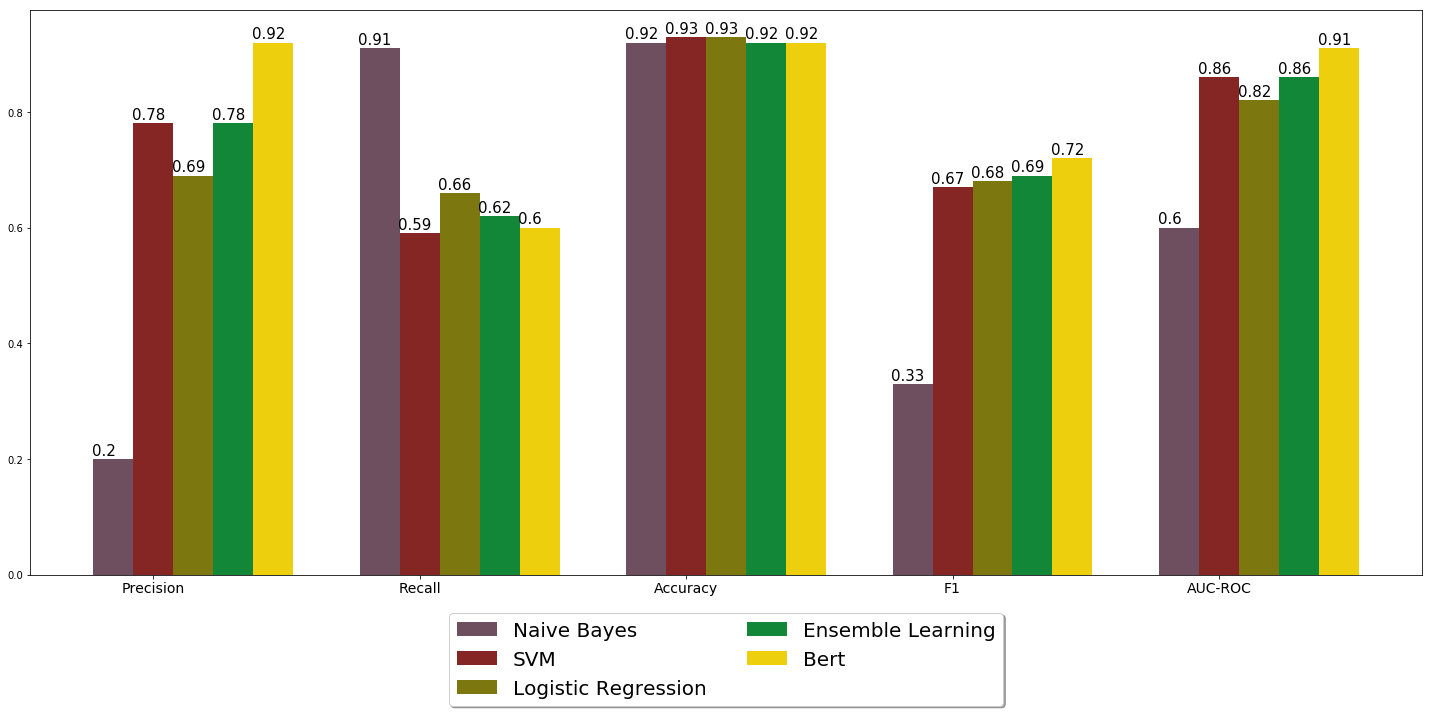

In [81]:
def show_plot():
    ind = ["Precision", "Recall", "Accuracy", "F1", "AUC-ROC"]
    n_groups = 5
    width = 0.15
    bar_width = 0.15
    index = np.arange(n_groups)
    # fig, ax = plt.subplots()
    nb = np.array([0.20,0.91,0.92,0.33,0.60])
    svm = np.array([0.78,0.59,0.93,0.67,0.86])
    lr = np.array([ 0.69, 0.66, 0.93, 0.68, 0.82])
    ensemble = np.array([ 0.78, 0.62, 0.92, 0.69, 0.86])
    bert = np.array([ 0.92, 0.60, 0.92, 0.72, 0.91])
    bars5 = nb.tolist() + svm.tolist() + lr.tolist() + ensemble.tolist() + bert.tolist()
    plt.figure(figsize=(20,10))

    plt.bar(index, nb, bar_width, label='Naive Bayes', color='#6e4f5f')
    plt.bar(index + width, svm, bar_width, label='SVM', color='#852524')
    plt.bar(index + 2*width, lr, bar_width, label='Logistic Regression', color='#7d770f')
    plt.bar(index + 3*width, ensemble, bar_width, label='Ensemble Learning', color='#138738')
    plt.bar(index + 4*width, bert, bar_width, label='Bert', color='#edcf0e')
    # plt.bar(ind, Content, width=0.6, label='Content', color='#ff884b', bottom=Advertising)
    # plt.bar(ind, Advertising, width=0.6, label='Advertising', color='#45335c')
    # plt.legend(loc='upper center', bbox_to_anchor=(0.5, -0.05), shadow=True, ncol=2)
    plt.xticks(index + width, ind, rotation=0, fontsize = 14)
    ax = plt.subplot(111)

    totals = []
    for i in ax.patches:
        totals.append(i.get_height())

    total = sum(totals)

    for i in ax.patches:
        # get_x pulls left or right; get_height pushes up or down
        ax.text(i.get_x()-.005, i.get_height()+.007, \
                str(round(i.get_height(), 2)), fontsize=15,
                    color='black')
    # ax.plot(ind, label=ind)
    # plt.legend(loc="upper right")
    ax.legend(loc='upper center', bbox_to_anchor=(0.5, -0.05), shadow=True, ncol=2, prop={'size': 20})

    plt.tight_layout()
    plt.savefig('comparison.png')
    plt.show()

show_plot()